In [1]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import pickle
from utils import flat, trace
from tqdm import tqdm
import psutil
import torch
import gc
from itertools import product
from multiprocessing import Pool
from tqdm import tqdm
from data import RANZCRDataset
from model import kaggle_metric
from utils import sigmoid, to_logits
from sklearn.metrics import roc_auc_score

In [2]:
train = pd.read_csv('../../input/kaggle/train.csv')
train_annotations = pd.read_csv('../../input/kaggle/train_annotations.csv', index_col='StudyInstanceUID')
sample_submission = pd.read_csv('../../input/kaggle/sample_submission.csv')
uids = train['StudyInstanceUID'].values
folds = joblib.load('folds.jl')
label_cols = [
    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
    'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
    'Swan Ganz Catheter Present'
]
ett_cols = label_cols[:3]
ngt_cols = label_cols[3:7]
cvc_cols = label_cols[7:10]
swan_cols = label_cols[10:]
img_path = '../../input/kaggle/train'
train_annotations['data'] = train_annotations['data'].apply(eval)
train = train.set_index('StudyInstanceUID')

In [142]:
sub = pd.read_csv('../../submission/final.csv', index_col='StudyInstanceUID')

In [134]:
sub5 = pd.read_csv('../../submission/v25/b5-fold1.csv', index_col='StudyInstanceUID')
sub4 = pd.read_csv('../../submission/v25/b4-fold1.csv', index_col='StudyInstanceUID')
sub6 = pd.read_csv('../../submission/v25/b6-fold1.csv', index_col='StudyInstanceUID')

In [135]:
trues = train.loc[sub5.index, label_cols]
# for c in sub.columns:
#     print(c, roc_auc_score(trues[c].values, sub[c].values))

In [136]:
print(kaggle_metric(sub5.values, trues.values))
print(kaggle_metric(sub4.values, trues.values))
print(kaggle_metric(sub6.values, trues.values))

0.9727492993710437
0.971989799218797
0.9717224245944394


In [137]:
sub = sub5*0.5+sub4*0.3+sub6*0.2
kaggle_metric(sub.values, trues.values)

0.9733036479428656

In [138]:
sub = (sub5**0.5)*0.5+(sub4**0.5)*0.3+(sub6**0.5)*0.2
kaggle_metric(sub.values, trues.values)

0.973310024387975

In [132]:
new_sub = sub.copy()
ett_sum = new_sub[ett_cols].sum(axis=1)
ett_fix_index = new_sub[ett_sum>0.5].index
new_sub.loc[ett_fix_index, ett_cols] /= np.expand_dims(ett_sum.loc[ett_fix_index].values, 1)
ngt_sum = new_sub[ngt_cols].sum(axis=1)
ngt_fix_index = new_sub[ngt_sum>0.8].index
new_sub.loc[ngt_fix_index, ngt_cols] /= np.expand_dims(ngt_sum.loc[ngt_fix_index].values, 1)
# cvc_sum = new_sub[cvc_cols].sum(axis=1)
# cvc_fix_index = new_sub[cvc_sum>2.4].index
# new_sub.loc[cvc_fix_index, cvc_cols] /= np.expand_dims(cvc_sum.loc[cvc_fix_index].values, 1)
kaggle_metric(new_sub.values, trues.values)

0.9734148180697795

In [3]:
sub = pd.read_csv('submission.csv')
display(sub.head())
sub = sub.set_index('StudyInstanceUID')
kaggle_metric(sub.values, train.loc[sub.index, label_cols].values)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.28811236589118628938...,0.000003,0.000056,0.000464,0.000017,0.000014,0.000009,0.000017,0.000192,0.003813,0.997894,1.708504e-06
1,1.2.826.0.1.3680043.8.498.88157424941800234649...,0.000926,0.055327,0.936103,0.711971,0.128178,0.013566,0.039892,0.004203,0.049670,0.006428,8.103901e-05
2,1.2.826.0.1.3680043.8.498.13301225220440590738...,0.000001,0.000019,0.000182,0.000018,0.000044,0.000020,0.000090,0.000092,0.003416,0.996847,9.393019e-07
3,1.2.826.0.1.3680043.8.498.11248355962522836935...,0.000105,0.029549,0.967493,0.011241,0.041837,0.825865,0.121825,0.000868,0.055546,0.996494,3.040517e-05
4,1.2.826.0.1.3680043.8.498.50125510495983316504...,0.000005,0.000018,0.000037,0.000064,0.000153,0.000167,0.000054,0.004850,0.204483,0.790836,5.449907e-06


0.9648423011220831

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [22]:
thresh = 5000
lr = LogisticRegression()
lr.fit(to_logits(sub.values)[:thresh], train.loc[sub.index[:thresh], 'CVC - Borderline'].values)

LogisticRegression()

In [23]:
roc_auc_score(train.loc[sub.index[thresh:], 'CVC - Borderline'].values, lr.predict_proba(to_logits(sub.values)[thresh:])[:,1])

0.8802559580337358

In [24]:
roc_auc_score(train.loc[sub.index[thresh:], 'CVC - Borderline'].values, sub['CVC - Borderline'].values[thresh:])

0.8813729480396146

In [4]:
for l in label_cols:
    print(l, kaggle_metric(sub[[l]].values, train.loc[sub.index, [l]].values))

ETT - Abnormal 0.9861666666666666
ETT - Borderline 0.9628470578453211
ETT - Normal 0.9912343765888126
NGT - Abnormal 0.9721589640544764
NGT - Borderline 0.9652922648995786
NGT - Incompletely Imaged 0.9864114167129492
NGT - Normal 0.9864016468008677
CVC - Abnormal 0.9485180906672951
CVC - Borderline 0.8828271589850596
CVC - Normal 0.9326136317750063
Swan Ganz Catheter Present 0.9987940373468822


['ETT - Normal']
['CVC - Normal']


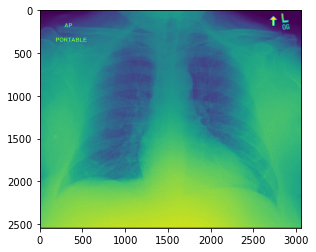

['CVC - Abnormal']
['CVC - Normal']


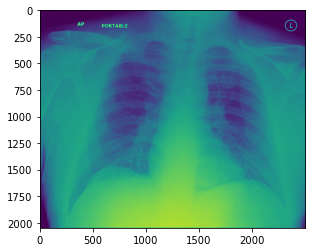

['CVC - Borderline']
['CVC - Normal']


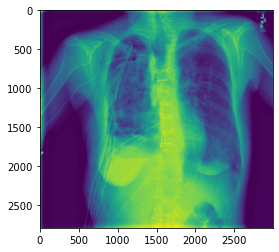

['ETT - Borderline' 'NGT - Normal' 'CVC - Borderline']
['ETT - Normal' 'NGT - Incompletely Imaged' 'CVC - Normal']


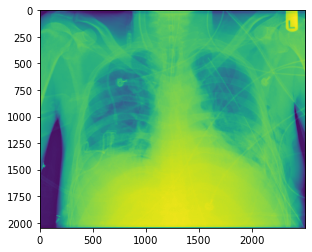

['CVC - Borderline']
['CVC - Normal']


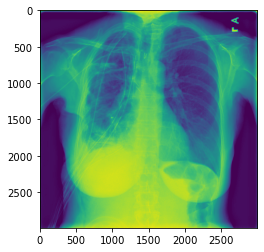

['NGT - Normal' 'CVC - Normal']
['CVC - Normal']


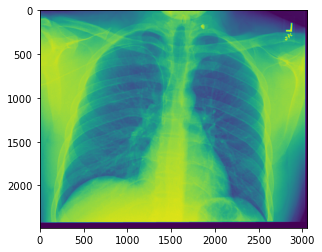

['CVC - Abnormal']
['CVC - Normal']


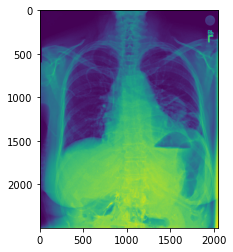

['CVC - Abnormal']
['CVC - Normal']


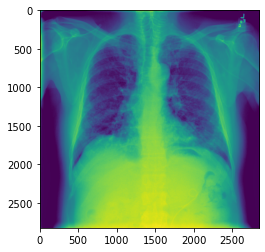

['ETT - Borderline' 'CVC - Abnormal']
['ETT - Normal']


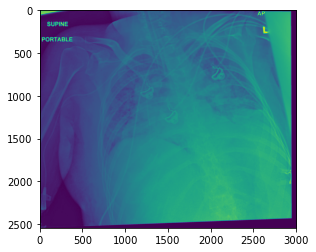

['NGT - Normal']
['CVC - Normal']


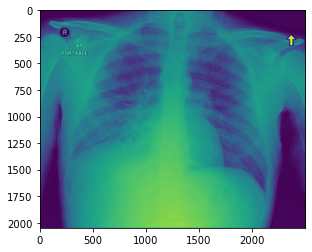

['NGT - Normal' 'CVC - Abnormal']
['ETT - Normal' 'CVC - Abnormal']


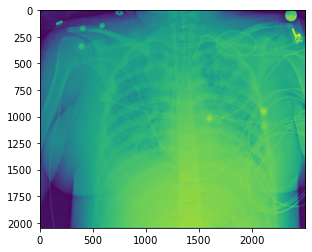

['NGT - Normal' 'CVC - Normal']
['CVC - Normal']


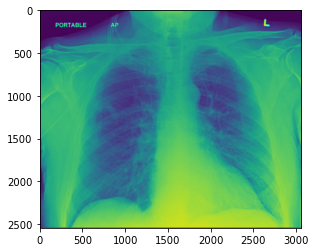

['CVC - Borderline']
['CVC - Normal']


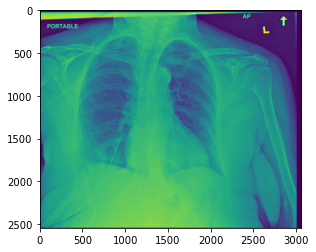

['CVC - Borderline']
['CVC - Normal']


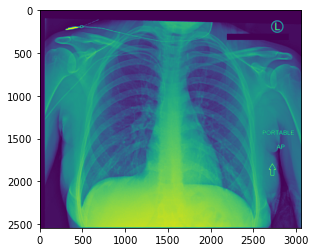

['ETT - Normal' 'NGT - Borderline' 'CVC - Normal']
['ETT - Borderline' 'NGT - Incompletely Imaged' 'CVC - Normal']


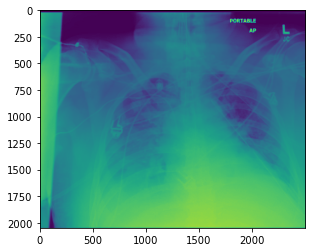

['ETT - Borderline' 'CVC - Borderline']
['ETT - Normal' 'CVC - Borderline']


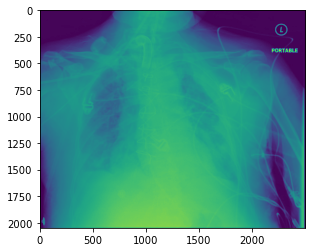

['CVC - Abnormal']
['CVC - Normal']


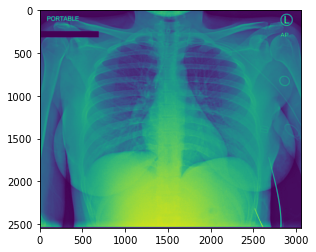

['CVC - Borderline']
['CVC - Normal']


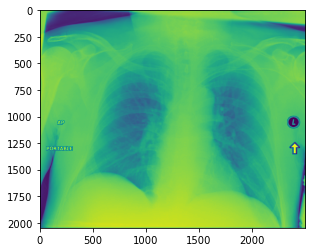

['ETT - Normal' 'NGT - Abnormal' 'CVC - Borderline']
['ETT - Normal' 'CVC - Normal']


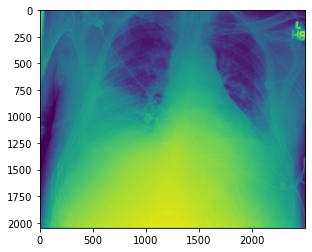

['ETT - Borderline' 'NGT - Normal' 'CVC - Borderline' 'CVC - Normal']
['ETT - Normal' 'NGT - Incompletely Imaged' 'CVC - Normal']


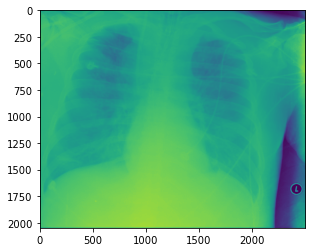

In [13]:
sub['loss'] = torch.nn.BCELoss(reduction='none')(torch.tensor(sub.values).float(), torch.tensor(train.loc[sub.index, label_cols].values).float()).mean(dim=1)
difficult_uids = sub.sort_values('loss', ascending=False).index[:20]
for uid in difficult_uids:
    data = joblib.load(f'../../input/processed/data/{uid}.jl')
    print(np.array(label_cols)[np.where(data['labels']>0.5)[0]])
    print(np.array(label_cols)[np.where(sub.loc[uid, label_cols].values>0.5)[0]])
    plt.imshow(data['img'])
    plt.show()